In [ ]:
!pip install networkx matplotlib anthropic sentence-transformers scikit-learn numpy

import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Set
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from collections import defaultdict, deque
import json

In [ ]:
class TreeKnowledgeGraph:
    """
    Hierarchical Knowledge Graph that mimics human learning patterns.
    Supports multi-hop reasoning and contextual navigation.
    """

    def __init__(self, embedding_model: str = 'all-MiniLM-L6-v2'):
        self.graph = nx.DiGraph()
        self.embedder = SentenceTransformer(embedding_model)
        self.node_embeddings = {}
        self.node_metadata = {}

    def add_node(self,
                 node_id: str,
                 content: str,
                 node_type: str = 'concept',
                 metadata: Optional[Dict] = None):
        """Add a node with semantic embedding and metadata."""

        embedding = self.embedder.encode(content, convert_to_tensor=False)

        self.graph.add_node(node_id,
                           content=content,
                           node_type=node_type,
                           metadata=metadata or {})

        self.node_embeddings[node_id] = embedding
        self.node_metadata[node_id] = {
            'content': content,
            'type': node_type,
            'metadata': metadata or {}
        }

    def add_edge(self,
                 parent: str,
                 child: str,
                 relationship: str = 'contains',
                 weight: float = 1.0):
        """Add hierarchical or associative edge between nodes."""
        self.graph.add_edge(parent, child,
                           relationship=relationship,
                           weight=weight)

    def get_ancestors(self, node_id: str, max_depth: int = 5) -> List[str]:
        """Get all ancestor nodes (hierarchical context)."""
        ancestors = []
        current = node_id
        depth = 0

        while depth < max_depth:
            predecessors = list(self.graph.predecessors(current))
            if not predecessors:
                break
            current = predecessors[0]
            ancestors.append(current)
            depth += 1

        return ancestors

    def get_descendants(self, node_id: str, max_depth: int = 2) -> List[str]:
        """Get all descendant nodes."""
        descendants = []
        queue = deque([(node_id, 0)])
        visited = {node_id}

        while queue:
            current, depth = queue.popleft()
            if depth >= max_depth:
                continue

            for child in self.graph.successors(current):
                if child not in visited:
                    visited.add(child)
                    descendants.append(child)
                    queue.append((child, depth + 1))

        return descendants

    def semantic_search(self, query: str, top_k: int = 5) -> List[Tuple[str, float]]:
        """Find most semantically similar nodes to query."""
        query_embedding = self.embedder.encode(query, convert_to_tensor=False)

        similarities = []
        for node_id, embedding in self.node_embeddings.items():
            sim = cosine_similarity(
                query_embedding.reshape(1, -1),
                embedding.reshape(1, -1)
            )[0][0]
            similarities.append((node_id, float(sim)))

        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

    def get_subgraph_context(self, node_id: str, depth: int = 2) -> Dict:
        """Get rich contextual information around a node."""
        context = {
            'node': self.node_metadata.get(node_id, {}),
            'ancestors': [],
            'descendants': [],
            'siblings': [],
            'related': []
        }

        ancestors = self.get_ancestors(node_id)
        context['ancestors'] = [
            self.node_metadata.get(a, {}) for a in ancestors
        ]

        descendants = self.get_descendants(node_id, depth)
        context['descendants'] = [
            self.node_metadata.get(d, {}) for d in descendants
        ]

        parents = list(self.graph.predecessors(node_id))
        if parents:
            siblings = list(self.graph.successors(parents[0]))
            siblings = [s for s in siblings if s != node_id]
            context['siblings'] = [
                self.node_metadata.get(s, {}) for s in siblings
            ]

        return context

In [ ]:
class MultiHopReasoningAgent:
    """
    Agent that performs intelligent multi-hop reasoning across the knowledge graph.
    """

    def __init__(self, kg: TreeKnowledgeGraph):
        self.kg = kg
        self.reasoning_history = []

    def reason(self,
               query: str,
               max_hops: int = 3,
               exploration_width: int = 3) -> Dict:
        """
        Perform multi-hop reasoning to answer a query.

        Strategy:
        1. Find initial relevant nodes (semantic search)
        2. Explore graph context around these nodes
        3. Perform breadth-first exploration with relevance scoring
        4. Aggregate information from multiple hops
        """

        reasoning_trace = {
            'query': query,
            'hops': [],
            'final_context': {},
            'reasoning_path': []
        }

        initial_nodes = self.kg.semantic_search(query, top_k=exploration_width)
        reasoning_trace['hops'].append({
            'hop_number': 0,
            'action': 'semantic_search',
            'nodes_found': initial_nodes
        })

        visited = set()
        current_frontier = [node_id for node_id, _ in initial_nodes]
        all_relevant_nodes = set(current_frontier)

        for hop in range(1, max_hops + 1):
            next_frontier = []
            hop_info = {
                'hop_number': hop,
                'explored_nodes': [],
                'new_discoveries': []
            }

            for node_id in current_frontier:
                if node_id in visited:
                    continue

                visited.add(node_id)

                context = self.kg.get_subgraph_context(node_id, depth=1)

                connected_nodes = []
                for ancestor in context['ancestors']:
                    if 'content' in ancestor:
                        connected_nodes.append(ancestor)

                for descendant in context['descendants']:
                    if 'content' in descendant:
                        connected_nodes.append(descendant)

                for sibling in context['siblings']:
                    if 'content' in sibling:
                        connected_nodes.append(sibling)

                relevant_connections = self._score_relevance(
                    query, connected_nodes, top_k=exploration_width
                )

                hop_info['explored_nodes'].append({
                    'node_id': node_id,
                    'content': self.kg.node_metadata[node_id]['content'][:100],
                    'connections_found': len(relevant_connections)
                })

                for conn_content, score in relevant_connections:
                    for nid, meta in self.kg.node_metadata.items():
                        if meta['content'] == conn_content and nid not in visited:
                            next_frontier.append(nid)
                            all_relevant_nodes.add(nid)
                            hop_info['new_discoveries'].append({
                                'node_id': nid,
                                'relevance_score': score
                            })
                            break

            reasoning_trace['hops'].append(hop_info)
            current_frontier = next_frontier

            if not current_frontier:
                break

        final_context = self._aggregate_context(query, all_relevant_nodes)
        reasoning_trace['final_context'] = final_context
        reasoning_trace['reasoning_path'] = list(all_relevant_nodes)

        self.reasoning_history.append(reasoning_trace)
        return reasoning_trace

    def _score_relevance(self,
                        query: str,
                        candidates: List[Dict],
                        top_k: int = 3) -> List[Tuple[str, float]]:
        """Score candidate nodes by relevance to query."""
        if not candidates:
            return []

        query_embedding = self.kg.embedder.encode(query)

        scores = []
        for candidate in candidates:
            content = candidate.get('content', '')
            if not content:
                continue

            candidate_embedding = self.kg.embedder.encode(content)
            similarity = cosine_similarity(
                query_embedding.reshape(1, -1),
                candidate_embedding.reshape(1, -1)
            )[0][0]
            scores.append((content, float(similarity)))

        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

    def _aggregate_context(self, query: str, node_ids: Set[str]) -> Dict:
        """Aggregate and rank information from all discovered nodes."""

        aggregated = {
            'total_nodes': len(node_ids),
            'hierarchical_paths': [],
            'key_concepts': [],
            'synthesized_answer': []
        }

        for node_id in node_ids:
            ancestors = self.kg.get_ancestors(node_id)
            if ancestors:
                path = ancestors[::-1] + [node_id]
                path_contents = [
                    self.kg.node_metadata[n]['content']
                    for n in path if n in self.kg.node_metadata
                ]
                aggregated['hierarchical_paths'].append(path_contents)

        for node_id in node_ids:
            meta = self.kg.node_metadata.get(node_id, {})
            aggregated['key_concepts'].append({
                'id': node_id,
                'content': meta.get('content', ''),
                'type': meta.get('type', 'unknown')
            })

        for node_id in node_ids:
            content = self.kg.node_metadata.get(node_id, {}).get('content', '')
            if content:
                aggregated['synthesized_answer'].append(content)

        return aggregated

    def explain_reasoning(self, trace: Dict) -> str:
        """Generate human-readable explanation of reasoning process."""

        explanation = [f"Query: {trace['query']}\n"]
        explanation.append(f"Total hops performed: {len(trace['hops']) - 1}\n")
        explanation.append(f"Total relevant nodes discovered: {len(trace['reasoning_path'])}\n\n")

        for hop_info in trace['hops']:
            hop_num = hop_info['hop_number']
            explanation.append(f"--- Hop {hop_num} ---")

            if hop_num == 0:
                explanation.append(f"Action: Initial semantic search")
                explanation.append(f"Found {len(hop_info['nodes_found'])} candidate nodes")
                for node_id, score in hop_info['nodes_found'][:3]:
                    explanation.append(f"  - {node_id} (relevance: {score:.3f})")
            else:
                explanation.append(f"Explored {len(hop_info['explored_nodes'])} nodes")
                explanation.append(f"Discovered {len(hop_info['new_discoveries'])} new relevant nodes")

            explanation.append("")

        explanation.append("\n--- Final Aggregated Context ---")
        context = trace['final_context']
        explanation.append(f"Total concepts integrated: {context['total_nodes']}")
        explanation.append(f"Hierarchical paths found: {len(context['hierarchical_paths'])}")

        return "\n".join(explanation)

In [ ]:
def build_software_development_kb() -> TreeKnowledgeGraph:
    """Build a comprehensive software development knowledge graph."""

    kg = TreeKnowledgeGraph()

    kg.add_node('root', 'Software Development and Computer Science', 'domain')

    kg.add_node('programming',
                'Programming encompasses writing, testing, and maintaining code to create software applications',
                'domain')
    kg.add_node('architecture',
                'Software Architecture involves designing the high-level structure and components of software systems',
                'domain')
    kg.add_node('devops',
                'DevOps combines development and operations to improve collaboration and deployment efficiency',
                'domain')

    kg.add_edge('root', 'programming', 'contains')
    kg.add_edge('root', 'architecture', 'contains')
    kg.add_edge('root', 'devops', 'contains')

    kg.add_node('python',
                'Python is a high-level, interpreted programming language known for readability and versatility in web, data science, AI, and automation',
                'language')
    kg.add_node('javascript',
                'JavaScript is a dynamic language primarily used for web development, enabling interactive client-side and server-side applications',
                'language')
    kg.add_node('rust',
                'Rust is a systems programming language focused on safety, concurrency, and performance without garbage collection',
                'language')

    kg.add_edge('programming', 'python', 'includes')
    kg.add_edge('programming', 'javascript', 'includes')
    kg.add_edge('programming', 'rust', 'includes')

    kg.add_node('python_basics',
                'Python basics include variables, data types, control flow, functions, and object-oriented programming fundamentals',
                'concept')
    kg.add_node('python_performance',
                'Python Performance optimization involves techniques like profiling, caching, using C extensions, and leveraging async programming',
                'concept')
    kg.add_node('python_data',
                'Python for Data Science uses libraries like NumPy, Pandas, and Scikit-learn for data manipulation, analysis, and machine learning',
                'concept')

    kg.add_edge('python', 'python_basics', 'contains')
    kg.add_edge('python', 'python_performance', 'contains')
    kg.add_edge('python', 'python_data', 'contains')

    kg.add_node('async_io',
                'Asynchronous IO in Python allows non-blocking operations using async/await syntax with asyncio library for concurrent tasks',
                'technique')
    kg.add_node('multiprocessing',
                'Python Multiprocessing uses separate processes to bypass GIL, enabling true parallel execution for CPU-bound tasks',
                'technique')
    kg.add_node('cython',
                'Cython compiles Python to C for significant performance gains, especially in numerical computations and tight loops',
                'tool')
    kg.add_node('profiling',
                'Python Profiling identifies performance bottlenecks using tools like cProfile, line_profiler, and memory_profiler',
                'technique')

    kg.add_edge('python_performance', 'async_io', 'contains')
    kg.add_edge('python_performance', 'multiprocessing', 'contains')
    kg.add_edge('python_performance', 'cython', 'contains')
    kg.add_edge('python_performance', 'profiling', 'contains')

    kg.add_node('event_loop',
                'Event Loop is the core of asyncio that manages and schedules asynchronous tasks, handling callbacks and coroutines',
                'concept')
    kg.add_node('coroutines',
                'Coroutines are special functions defined with async def that can pause execution with await, enabling cooperative multitasking',
                'concept')
    kg.add_node('asyncio_patterns',
                'AsyncIO patterns include gather for concurrent execution, create_task for background tasks, and queues for producer-consumer',
                'pattern')

    kg.add_edge('async_io', 'event_loop', 'contains')
    kg.add_edge('async_io', 'coroutines', 'contains')
    kg.add_edge('async_io', 'asyncio_patterns', 'contains')

    kg.add_node('microservices',
                'Microservices architecture decomposes applications into small, independent services that communicate via APIs',
                'pattern')
    kg.add_edge('architecture', 'microservices', 'contains')
    kg.add_edge('async_io', 'microservices', 'related_to')

    kg.add_node('containers',
                'Containers package applications with dependencies into isolated units, ensuring consistency across environments',
                'technology')
    kg.add_edge('devops', 'containers', 'contains')
    kg.add_edge('microservices', 'containers', 'deployed_with')

    kg.add_node('numpy_optimization',
                'NumPy optimization uses vectorization and broadcasting to avoid Python loops, leveraging optimized C and Fortran libraries',
                'technique')
    kg.add_edge('python_data', 'numpy_optimization', 'contains')
    kg.add_edge('python_performance', 'numpy_optimization', 'related_to')

    return kg

In [ ]:
def visualize_knowledge_graph(kg: TreeKnowledgeGraph,
                              highlight_nodes: Optional[List[str]] = None):
    """Visualize the knowledge graph structure."""

    plt.figure(figsize=(16, 12))

    pos = nx.spring_layout(kg.graph, k=2, iterations=50, seed=42)

    node_colors = []
    for node in kg.graph.nodes():
        if highlight_nodes and node in highlight_nodes:
            node_colors.append('yellow')
        else:
            node_type = kg.graph.nodes[node].get('node_type', 'concept')
            color_map = {
                'domain': 'lightblue',
                'language': 'lightgreen',
                'concept': 'lightcoral',
                'technique': 'lightyellow',
                'tool': 'lightpink',
                'pattern': 'lavender',
                'technology': 'peachpuff'
            }
            node_colors.append(color_map.get(node_type, 'lightgray'))

    nx.draw_networkx_nodes(kg.graph, pos,
                          node_color=node_colors,
                          node_size=2000,
                          alpha=0.9)

    nx.draw_networkx_edges(kg.graph, pos,
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20,
                          alpha=0.6,
                          width=2)

    nx.draw_networkx_labels(kg.graph, pos,
                           font_size=8,
                           font_weight='bold')

    plt.title("Tree-KG: Hierarchical Knowledge Graph", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def run_demo():
    """Run complete demonstration of Tree-KG system."""

    print("=" * 80)
    print("Tree-KG: Hierarchical Knowledge Graph Demo")
    print("=" * 80)
    print()

    print("Building knowledge graph...")
    kg = build_software_development_kb()
    print(f"✓ Created graph with {kg.graph.number_of_nodes()} nodes and {kg.graph.number_of_edges()} edges\n")

    print("Visualizing knowledge graph...")
    visualize_knowledge_graph(kg)

    agent = MultiHopReasoningAgent(kg)

    queries = [
        "How can I improve Python performance for IO-bound tasks?",
        "What are the best practices for async programming?",
        "How does microservices architecture relate to Python?"
    ]

    for i, query in enumerate(queries, 1):
        print(f"\n{'=' * 80}")
        print(f"QUERY {i}: {query}")
        print('=' * 80)

        trace = agent.reason(query, max_hops=3, exploration_width=3)

        explanation = agent.explain_reasoning(trace)
        print(explanation)

        print("\n--- Sample Hierarchical Paths ---")
        for j, path in enumerate(trace['final_context']['hierarchical_paths'][:3], 1):
            print(f"\nPath {j}:")
            for k, concept in enumerate(path):
                indent = "  " * k
                print(f"{indent}→ {concept[:80]}...")

        print("\n--- Synthesized Context ---")
        answer_parts = trace['final_context']['synthesized_answer'][:5]
        for part in answer_parts:
            print(f"• {part[:150]}...")

        print()

    print("\nVisualizing reasoning path for last query...")
    last_trace = agent.reasoning_history[-1]
    visualize_knowledge_graph(kg, highlight_nodes=last_trace['reasoning_path'])

    print("\n" + "=" * 80)
    print("Demo complete!")
    print("=" * 80)

In [ ]:
class AdvancedTreeKG(TreeKnowledgeGraph):
    """Extended Tree-KG with advanced features."""

    def __init__(self, embedding_model: str = 'all-MiniLM-L6-v2'):
        super().__init__(embedding_model)
        self.node_importance = {}

    def compute_node_importance(self):
        """Compute importance scores using PageRank-like algorithm."""
        if self.graph.number_of_nodes() == 0:
            return

        pagerank = nx.pagerank(self.graph)
        betweenness = nx.betweenness_centrality(self.graph)

        for node in self.graph.nodes():
            self.node_importance[node] = {
                'pagerank': pagerank.get(node, 0),
                'betweenness': betweenness.get(node, 0),
                'combined': pagerank.get(node, 0) * 0.7 + betweenness.get(node, 0) * 0.3
            }

    def find_shortest_path_with_context(self,
                                       source: str,
                                       target: str) -> Dict:
        """Find shortest path and extract all context along the way."""
        try:
            path = nx.shortest_path(self.graph, source, target)

            context = {
                'path': path,
                'path_length': len(path) - 1,
                'nodes_detail': []
            }

            for node in path:
                detail = {
                    'id': node,
                    'content': self.node_metadata.get(node, {}).get('content', ''),
                    'importance': self.node_importance.get(node, {}).get('combined', 0)
                }
                context['nodes_detail'].append(detail)

            return context
        except nx.NetworkXNoPath:
            return {'path': [], 'error': 'No path exists'}

Tree-KG: Hierarchical Knowledge Graph Demo

Building knowledge graph...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Created graph with 20 nodes and 22 edges

Visualizing knowledge graph...


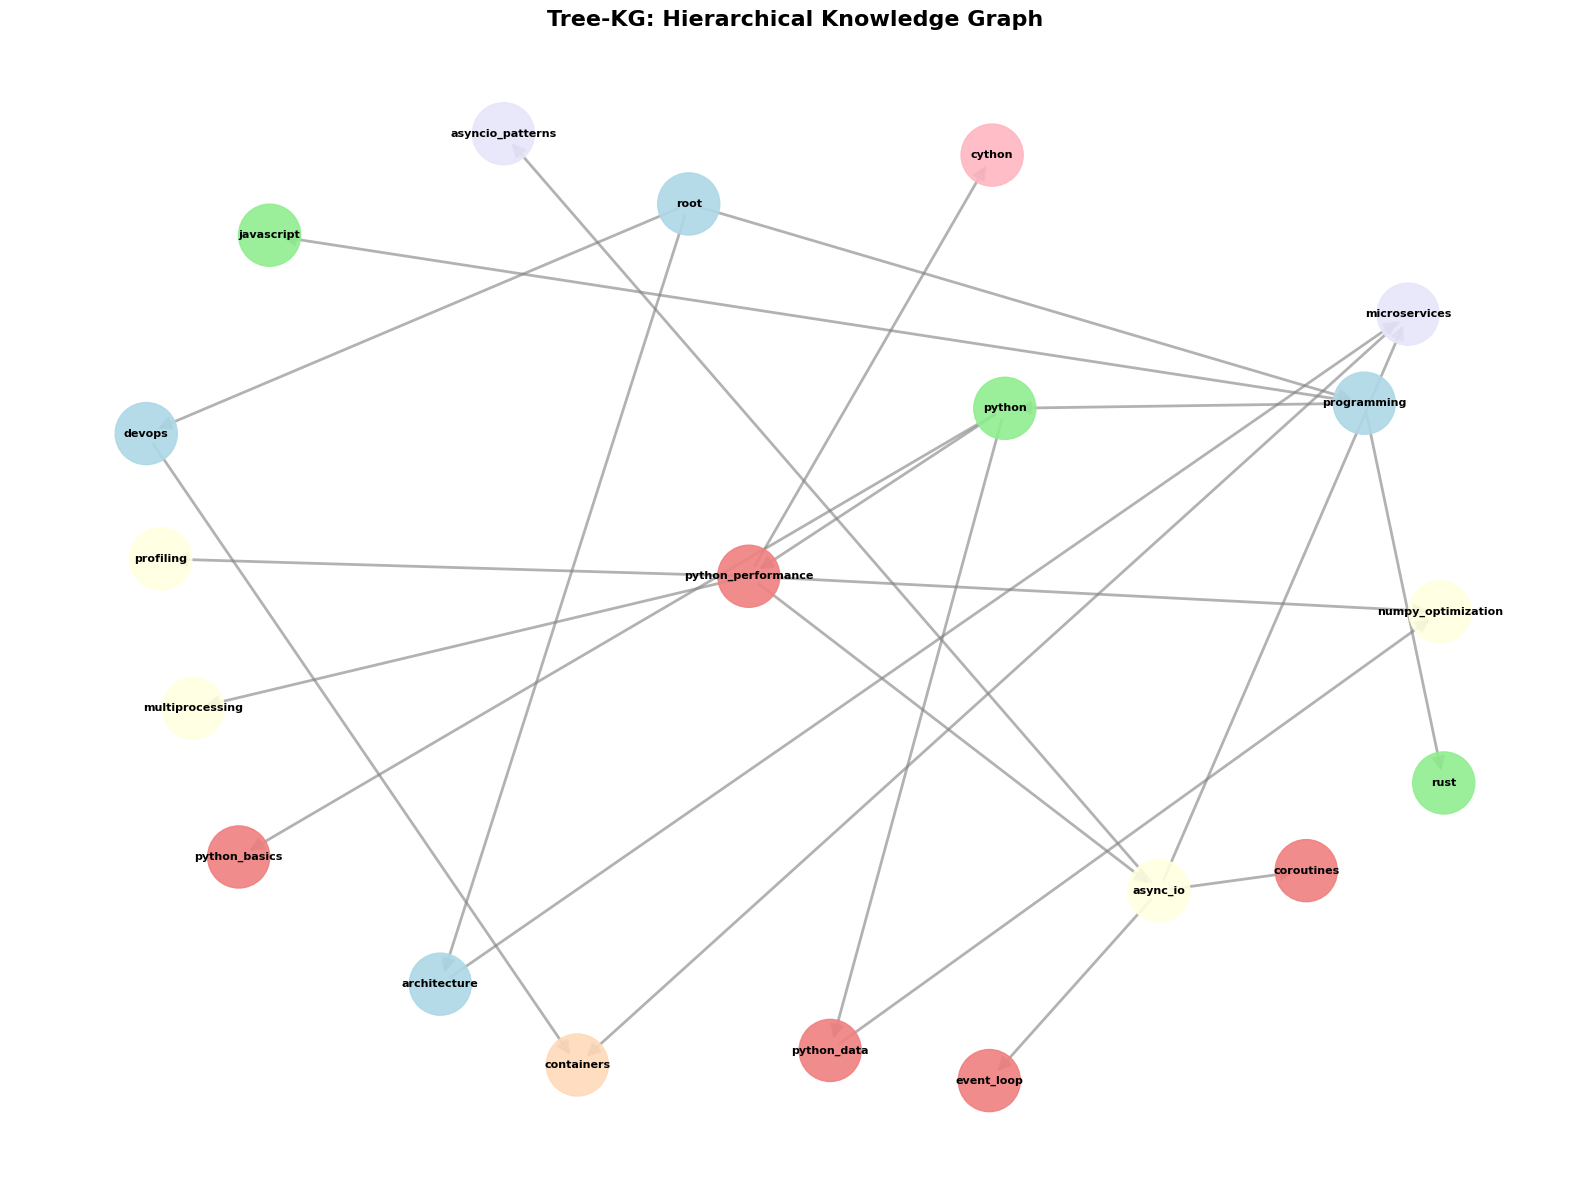


QUERY 1: How can I improve Python performance for IO-bound tasks?
Query: How can I improve Python performance for IO-bound tasks?

Total hops performed: 2

Total relevant nodes discovered: 4


--- Hop 0 ---
Action: Initial semantic search
Found 3 candidate nodes
  - python_performance (relevance: 0.616)
  - async_io (relevance: 0.582)
  - multiprocessing (relevance: 0.549)

--- Hop 1 ---
Explored 3 nodes
Discovered 6 new relevant nodes

--- Hop 2 ---
Explored 1 nodes
Discovered 0 new relevant nodes


--- Final Aggregated Context ---
Total concepts integrated: 4
Hierarchical paths found: 4

--- Sample Hierarchical Paths ---

Path 1:
→ Software Development and Computer Science...
  → Programming encompasses writing, testing, and maintaining code to create softwar...
    → Python is a high-level, interpreted programming language known for readability a...
      → Python Performance optimization involves techniques like profiling, caching, usi...

Path 2:
→ Software Development and Comput

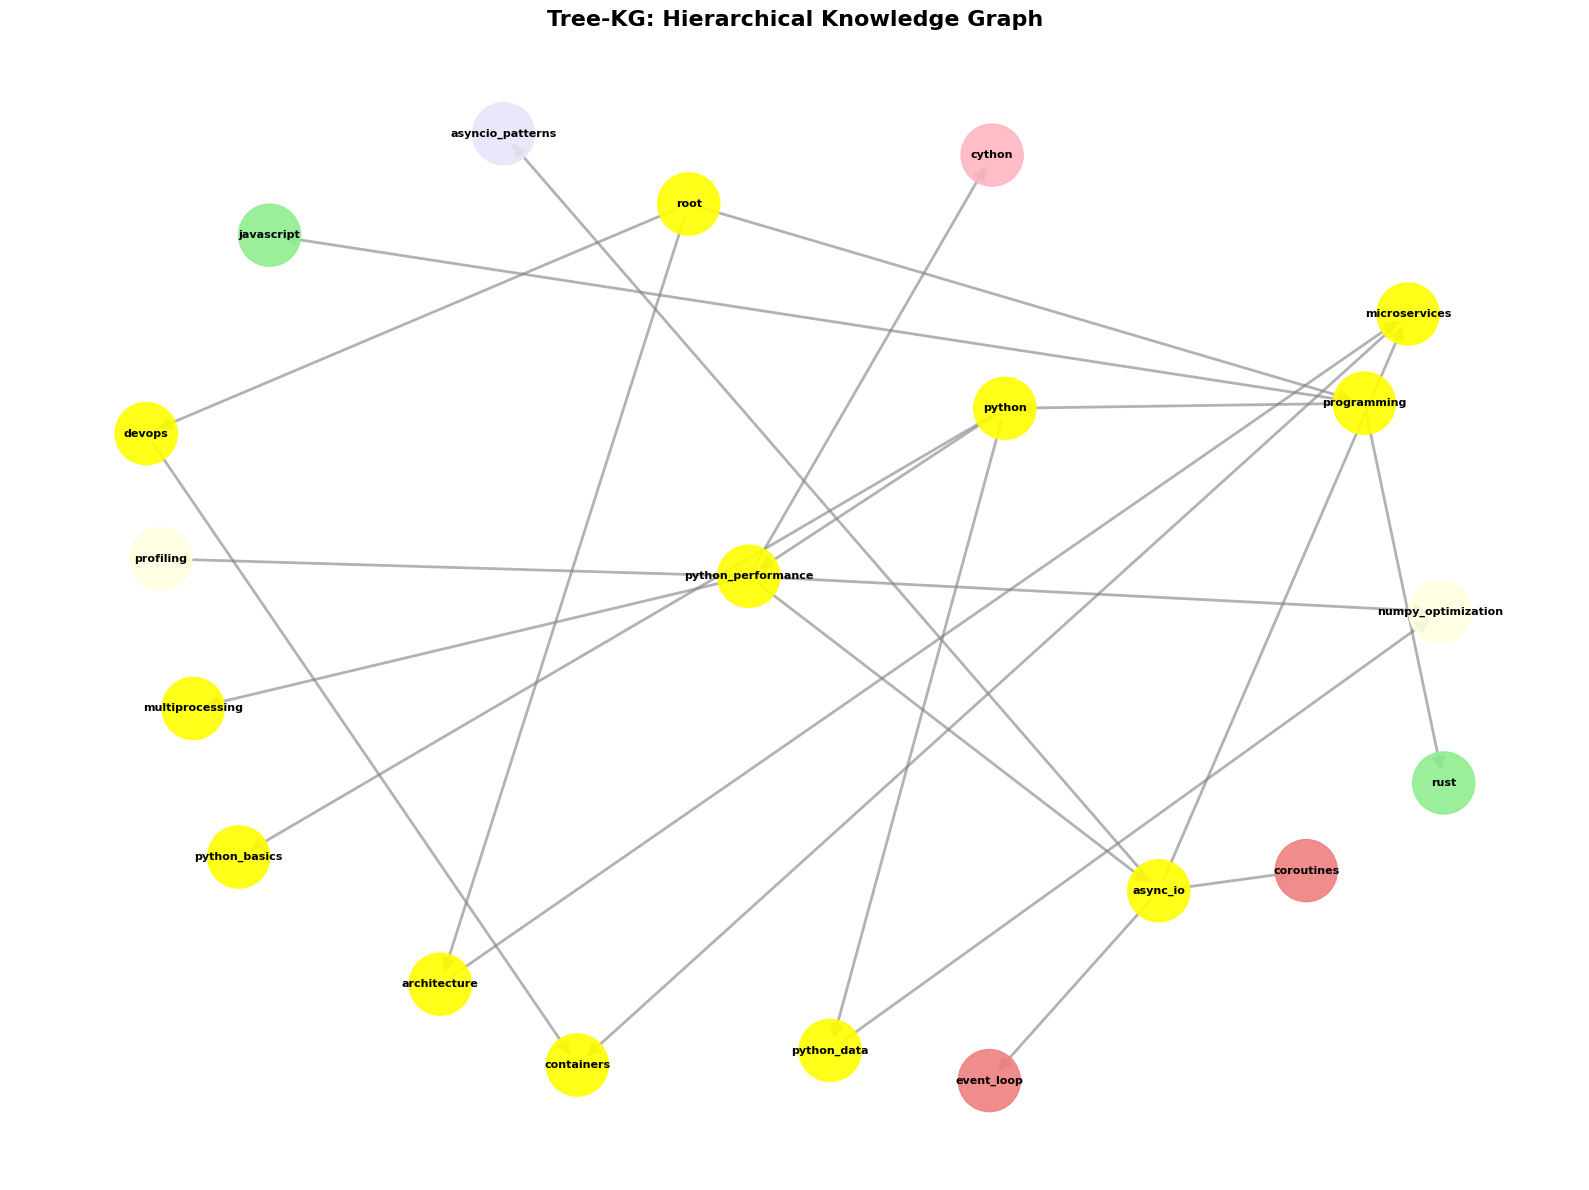


Demo complete!


ADVANCED FEATURES DEMO

Building advanced Tree-KG...
Computing node importance scores...

Top 5 most important nodes:
  containers: Containers package applications with dependencies into isola...
    Combined score: 0.0933
  microservices: Microservices architecture decomposes applications into smal...
    Combined score: 0.0581
  numpy_optimization: NumPy optimization uses vectorization and broadcasting to av...
    Combined score: 0.0551
  python_performance: Python Performance optimization involves techniques like pro...
    Combined score: 0.0549
  python: Python is a high-level, interpreted programming language kno...
    Combined score: 0.0522

✓ Tree-KG Tutorial Complete!

Key Takeaways:
1. Tree-KG enables contextual navigation vs simple chunk retrieval
2. Multi-hop reasoning discovers relevant information across graph structure
3. Hierarchical organization mirrors human learning patterns
4. Semantic search + graph traversal = powerful RAG alternative


In [1]:
if __name__ == "__main__":
    run_demo()

    print("\n\n" + "=" * 80)
    print("ADVANCED FEATURES DEMO")
    print("=" * 80)

    print("\nBuilding advanced Tree-KG...")
    adv_kg = AdvancedTreeKG()

    adv_kg = build_software_development_kb()

    adv_kg_new = AdvancedTreeKG()
    adv_kg_new.graph = adv_kg.graph
    adv_kg_new.node_embeddings = adv_kg.node_embeddings
    adv_kg_new.node_metadata = adv_kg.node_metadata

    print("Computing node importance scores...")
    adv_kg_new.compute_node_importance()

    print("\nTop 5 most important nodes:")
    sorted_nodes = sorted(
        adv_kg_new.node_importance.items(),
        key=lambda x: x[1]['combined'],
        reverse=True
    )[:5]

    for node, scores in sorted_nodes:
        content = adv_kg_new.node_metadata[node]['content'][:60]
        print(f"  {node}: {content}...")
        print(f"    Combined score: {scores['combined']:.4f}")

    print("\n✓ Tree-KG Tutorial Complete!")
    print("\nKey Takeaways:")
    print("1. Tree-KG enables contextual navigation vs simple chunk retrieval")
    print("2. Multi-hop reasoning discovers relevant information across graph structure")
    print("3. Hierarchical organization mirrors human learning patterns")
    print("4. Semantic search + graph traversal = powerful RAG alternative")